In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [87]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('AMZN', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,2.730729,2.966667,2.665625,2.957813,2.957813,785844000
1999-01-05,2.739063,3.243750,2.662500,3.112500,3.112500,1257464000
1999-01-06,3.409375,3.509375,3.350000,3.450000,3.450000,723532000
1999-01-07,3.428125,4.006250,3.325000,3.971875,3.971875,945492000
1999-01-08,4.606250,4.978125,3.800000,4.006250,4.006250,1333244000


In [88]:
end = '2024-03-30'
start = '2020-01-02'

testingData = yf.download('AMZN', start=start, end=end)
testingData


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000
...,...,...,...,...,...,...
2024-03-22,177.750000,179.259995,176.750000,178.869995,178.869995,27964100
2024-03-25,178.009995,180.990005,177.240005,179.710007,179.710007,29815500
2024-03-26,180.149994,180.449997,177.949997,178.300003,178.300003,29659000


In [89]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [90]:
trainData


array([ 2.95781302,  3.11249995,  3.45000005, ..., 93.43849945,
       93.48999786, 92.34449768])

In [91]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [92]:
n_steps = 30

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [95]:
#LSTM Model
from tensorflow.keras.optimizers import Adam

model = Sequential()

#Layer 1
model.add(LSTM(units=50,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.5))
#Layer 2
model.add(LSTM(units=50,return_sequences=False))
model.add(Dropout(0.5))
#Layer 3
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10,
    restore_best_weights=True
)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_26 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_27 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
#Method to plot the training metric vs validation metric
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [97]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 2s 9ms/step - loss: 0.0899 - root_mean_squared_error: 0.2999 - mean_absolute_error: 0.1665


In [98]:
len(xTrain)

5252

Epoch 1/100
66/66 [==============================] - 6s 39ms/step - loss: 7.8250e-04 - root_mean_squared_error: 0.0280 - mean_absolute_error: 0.0195 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2425 - val_mean_absolute_error: 0.2074
Epoch 2/100
66/66 [==============================] - 3s 39ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - mean_absolute_error: 0.0372 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726 - val_mean_absolute_error: 0.1513
Epoch 3/100
66/66 [==============================] - 3s 50ms/step - loss: 6.4572e-04 - root_mean_squared_error: 0.0254 - mean_absolute_error: 0.0197 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460 - val_mean_absolute_error: 0.0357
Epoch 4/100
66/66 [==============================] - 2s 36ms/step - loss: 3.2164e-04 - root_mean_squared_error: 0.0179 - mean_absolute_error: 0.0107 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.0394
Epoch 5/100
66/66 [=========================

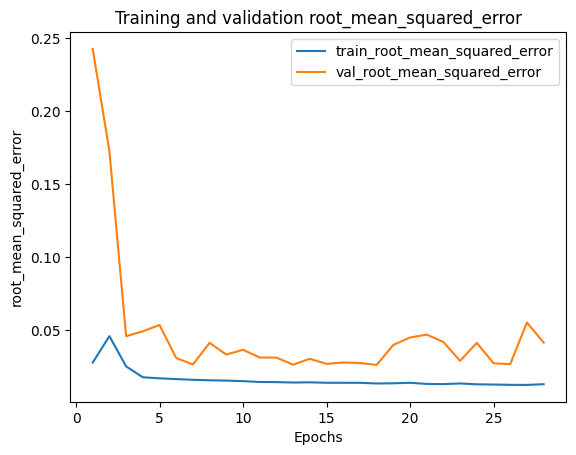

In [99]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=64,
    validation_split = 0.2,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [102]:
n_steps = 30

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])

xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))


In [103]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 3s 22ms/step


0.07155212604758086

In [104]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 0s 9ms/step - loss: 0.0051 - root_mean_squared_error: 0.0716 - mean_absolute_error: 0.0547


In [105]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)

df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [106]:
df = df1.join(df2)
df = df.set_index('Date')
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,94.900497,99.622856
2020-01-03,93.748497,100.491028
2020-01-06,95.143997,101.324074
2020-01-07,95.343002,102.126442
2020-01-08,94.598503,102.859787
...,...,...
2024-02-23,174.990005,NaN
2024-02-26,174.729996,NaN
2024-02-27,173.539993,NaN


Results

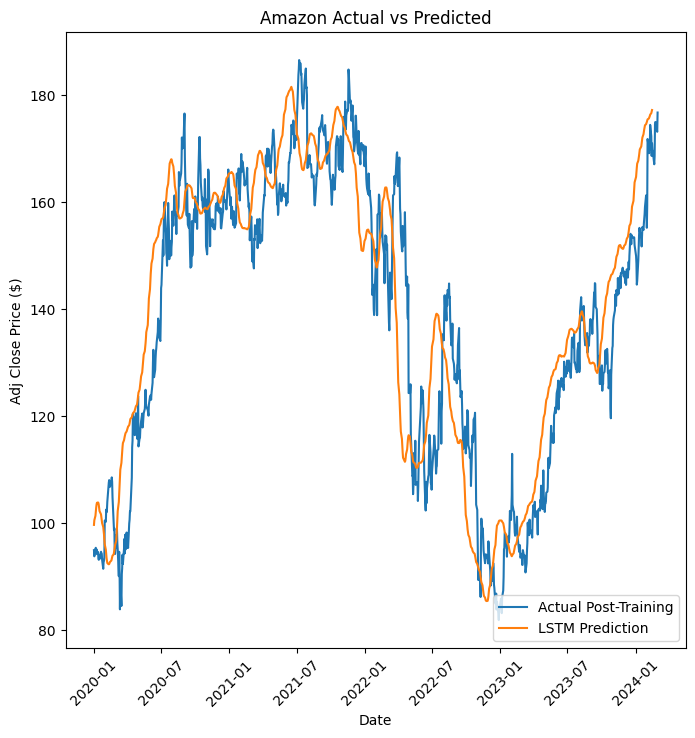

In [107]:
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(8,8))
plt.title('Amazon Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')

plt.xticks(rotation=45)
plt.show()

In [117]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(24):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=24, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)


1/1 [==============================] - 0s 24ms/step
            Predicted Adj Close
2024-03-29           177.547958
2024-04-01           177.808868
2024-04-02           178.016281
2024-04-03           178.188568
2024-04-04           178.330032
2024-04-05           178.442581
2024-04-08           178.542206
2024-04-09           178.633423
2024-04-10           178.719955
2024-04-11           178.801956
2024-04-12           178.874786
2024-04-15           178.943878
2024-04-16           179.013107
2024-04-17           179.086609
2024-04-18           179.159042
2024-04-19           179.224945
2024-04-22           179.292847
2024-04-23           179.364975
2024-04-24           179.430283
2024-04-25           179.493591
2024-04-26           179.553879
2024-04-29           179.621262
2024-04-30           179.687531
2024-05-01           179.750854


In [121]:
predicted_df

,Predicted Adj Close
2024-03-29,177.547958
2024-04-01,177.808868
2024-04-02,178.016281
2024-04-03,178.188568
2024-04-04,178.330032
2024-04-05,178.442581
2024-04-08,178.542206
2024-04-09,178.633423
2024-04-10,178.719955
2024-04-11,178.801956
